# Gene Expression Analysis of Project TCGA-CHOL


### Qiong Liu
### April 7th, 2022

Cholangiocarcinoma (CCA) is aggressive cancer found in the slender tubes that carry the digestive fluid bile through the liver. The Cancer Genome Atlas (TCGA) program contains abundant molecular profilings of over 20,000 primary cancer and matched normal samples spanning 33 cancer types. In this notebook, we demonstrated how to retrieve RNA expression data of project TCGA-CHOL from [Genomic Data Commons (GDC) data portal](https://portal.gdc.cancer.gov/), and perform data analysis and visualization using a pipeline provided by an R package `GDCRNATools`. 

This pipeline was modified based on the manual of [GDCRNATools](http://bioconductor.org/packages/devel/bioc/vignettes/GDCRNATools/inst/doc/GDCRNATools.html).

**References**

- Li R, Qu H, Wang S, Wei J, Le Zhang, Ma R, Lu J, Zhu J, Zhong W, Jia Z (2021). GDCRNATools: GDCRNATools: an R/Bioconductor package for integrative analysis of lncRNA, mRNA, and miRNA data in GDC. https://doi.org/10.1093/bioinformatics/bty124

- Love, M.I., Huber, W. & Anders, S. Moderated estimation of fold change and dispersion for RNA-seq data with DESeq2. Genome Biol 15, 550 (2014). https://doi.org/10.1186/s13059-014-0550-8

- Ritchie, M. E., Phipson, B., Wu, D., Hu, Y., Law, C. W., Shi, W., & Smyth, G. K. (2015). limma powers differential expression analyses for RNA-sequencing and microarray studies. Nucleic acids research, 43(7), e47. https://doi.org/10.1093/nar/gkv007

- Robinson, M. D., McCarthy, D. J., & Smyth, G. K. (2010). edgeR: a Bioconductor package for differential expression analysis of digital gene expression data. Bioinformatics (Oxford, England), 26(1), 139–140. https://doi.org/10.1093/bioinformatics/btp616

---


## Contents

- [Data preparation](#Data-Preparation)
- [Differential expression analysis](#Differential-expression-analysis)
- [Functional enrichment analysis](#Functional-enrichment-analysis)
- [Univariate survival analysis](#Univariate-survival-analysis)


## Data Preparation

### Import R packages

In [1]:
# suppress warnings (to include warnings,set warn to 0)
options(warn=-1)

library(GDCRNATools)
library(dplyr)
library(tidyr)





##############################################################################
Pathview is an open source software package distributed under GNU General
Public License version 3 (GPLv3). Details of GPLv3 is available at
http://www.gnu.org/licenses/gpl-3.0.html. Particullary, users are required to
formally cite the original Pathview paper (not just mention it) in publications
or products. For details, do citation("pathview") within R.

The pathview downloads and uses KEGG data. Non-academic uses may require a KEGG
license agreement (details at http://www.kegg.jp/kegg/legal.html).
##############################################################################


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### Download GDC data transfer tool

The R package of `GDCRNATools` uses `gdc-client` data transfer to download the object file. Run the command below to download and unzip gdc-client.

In [3]:
system("wget https://gdc.cancer.gov/files/public/file/gdc-client_v1.6.1_Ubuntu_x64.zip")
unzip("gdc-client_v1.6.1_Ubuntu_x64.zip", exdir=".")

### Data download

- The block blow fixes a bug in gdcGetURL that leads to downloading error, and overwrites the orginal function `gdcGetURL` within the pakcage namespace.

In [2]:
gdcGetURL_new <- function(project.id, data.type) {
    urlAPI <- 'https://api.gdc.cancer.gov/files?'
    
    if (data.type=='RNAseq') {
        data.category <- 'Transcriptome Profiling'
        data.type <- 'Gene Expression Quantification'
        workflow.type <- 'STAR - Counts'
    } else if (data.type=='miRNAs') {
        data.category <- 'Transcriptome Profiling'
        data.type <- 'Isoform Expression Quantification'
        workflow.type <- 'BCGSC miRNA Profiling'
    } else if (data.type=='Clinical') {
        data.category <- 'Clinical'
        data.type <- 'Clinical Supplement'
        workflow.type <- NA
    } else if (data.type=='pre-miRNAs') {
        data.category <- 'Transcriptome Profiling'
        data.type <- 'miRNA Expression Quantification'
        workflow.type <- 'BCGSC miRNA Profiling'
    }
    
    project <- paste('{"op":"in","content":{"field":"cases.',
        'project.project_id","value":["', 
        project.id, '"]}}', sep='')
    dataCategory <- paste('{"op":"in","content":{"field":"files.', 
        'data_category","value":"', data.category, '"}}', sep='')
    dataType <- paste('{"op":"in","content":{"field":"files.data_type",',
        '"value":"', data.type, '"}}', sep='')
    workflowType <- paste('{"op":"in","content":{"field":"files.',
        'analysis.workflow_type","value":"', workflow.type, '"}}', sep='')
    
    
    if (is.na(workflow.type)) {
        dataFormat <- paste('{"op":"in","content":{"field":"files.',
            'data_format","value":"', 'BCR XML', '"}}', sep='')
        content <- paste(project, dataCategory, dataType, dataFormat, sep=',')
    } else {
        content <- paste(project, dataCategory, dataType, 
            workflowType, sep=',')
    }
    
    filters <- paste('filters=',URLencode(paste('{"op":"and","content":[', 
        content, ']}', sep='')),sep='')
    
    expand <- paste('analysis', 'analysis.input_files', 'associated_entities',
        'cases', 'cases.diagnoses','cases.diagnoses.treatments', 
        'cases.demographic', 'cases.project', 'cases.samples', 
        'cases.samples.portions', 'cases.samples.portions.analytes', 
        'cases.samples.portions.analytes.aliquots',
        'cases.samples.portions.slides', sep=',')
    
    expand <- paste('expand=', expand, sep='')
    
    payload <- paste(filters, 'pretty=true', 'format=JSON', 
        'size=10000', expand, sep='&')
    url <- paste(urlAPI, payload, sep='')
    
    return (url)
}

toolenv <- environment(get("gdcGetURL", envir = asNamespace("GDCRNATools")))
unlockBinding("gdcGetURL", toolenv)
assignInNamespace("gdcGetURL", gdcGetURL_new, ns="GDCRNATools", envir=toolenv)
assign("gdcGetURL", gdcGetURL_new)
lockBinding("gdcGetURL", toolenv)


- Download gene expression quantificatioin files of project TCGA-CHOL using gen3-client

In [4]:
# download RNA-seq quantification files of project TCGA-CHOL
# downloaded files will be stored under TCGA-CHOL_0406/RNAseq folder, respectively
project <- 'TCGA-CHOL_0406'
rnadir <- paste(project, 'RNAseq', sep='/')

# Download RNAseq data 
gdcRNADownload(project.id     = 'TCGA-CHOL', 
               data.type      = 'RNAseq', 
               write.manifest = FALSE,
               method         = 'gdc-client',
               directory      = rnadir)


- Query metadata associated with gene expression quantification files from GDC graph

In [3]:
# Query metadata(e.g. patient gender, vital status) from GDC graph
# Metadata associated with RNA-seq quantification file
metaMatrix.RNA <- gdcParseMetadata(project.id = 'TCGA-CHOL',
                                   data.type  = 'RNAseq', 
                                   write.meta = FALSE)
# Filter duplicates
metaMatrix.RNA <- gdcFilterDuplicate(metaMatrix.RNA)

# Filter non-Primary Tumor and non-Solid Tissue Normal samples in RNAseq metadata
metaMatrix.RNA <- gdcFilterSampleType(metaMatrix.RNA)


Removed 0 samples

Removed 0 samples



- Inspect first 5 rows of dataframe `metaMatrix.MIR`

In [4]:
metaMatrix.RNA[1:5,]

,file_name,file_id,patient,sample,submitter_id,entity_submitter_id,sample_type,gender,age_at_diagnosis,tumor_stage,tumor_grade,days_to_death,days_to_last_follow_up,vital_status,project_id
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
TCGA-3X-AAV9-01A,913eff0d-52b9-4e73-9351-970393b2f523.rna_seq.augmented_star_gene_counts.tsv,43ac405a-93dc-4241-86be-3f034ba1eafb,TCGA-3X-AAV9,TCGA-3X-AAV9-01,TCGA-3X-AAV9-01A,TCGA-3X-AAV9-01A-72R-A41I-07,PrimaryTumor,male,26349,NA,NA,339,NA,Dead,TCGA-CHOL
TCGA-3X-AAVA-01A,ad57a542-3089-47f7-8750-382adff65e97.rna_seq.augmented_star_gene_counts.tsv,37f36a91-44ec-433a-a7ce-06f982b54f52,TCGA-3X-AAVA,TCGA-3X-AAVA-01,TCGA-3X-AAVA-01A,TCGA-3X-AAVA-01A-11R-A41I-07,PrimaryTumor,female,18303,NA,NA,445,NA,Dead,TCGA-CHOL
TCGA-3X-AAVB-01A,40538197-4671-4420-928e-7262cf452396.rna_seq.augmented_star_gene_counts.tsv,74f1a110-9ebb-4f5b-a6d0-4575602b4195,TCGA-3X-AAVB,TCGA-3X-AAVB-01,TCGA-3X-AAVB-01A,TCGA-3X-AAVB-01A-31R-A41I-07,PrimaryTumor,female,25819,NA,NA,NA,402,Alive,TCGA-CHOL
TCGA-3X-AAVC-01A,2cfef5ef-b6f6-43fa-a5f6-8959c24ed654.rna_seq.augmented_star_gene_counts.tsv,1615db37-9b6e-4aca-b4e1-354beaa5fc3a,TCGA-3X-AAVC,TCGA-3X-AAVC-01,TCGA-3X-AAVC-01A,TCGA-3X-AAVC-01A-21R-A41I-07,PrimaryTumor,female,26493,NA,NA,NA,709,Alive,TCGA-CHOL
TCGA-3X-AAVE-01A,edb6e6ac-5199-445b-a9d6-c08ec61c9dea.rna_seq.augmented_star_gene_counts.tsv,9432a7f6-59ad-44e1-b18b-5b7a366b3b88,TCGA-3X-AAVE,TCGA-3X-AAVE-01,TCGA-3X-AAVE-01A,TCGA-3X-AAVE-01A-11R-A41I-07,PrimaryTumor,male,21943,NA,NA,NA,650,Alive,TCGA-CHOL


- Next two blocks generate `brief summary tables` for several numeric and factor clinical vairables in metaMatrix.RNA (all the patients involved in this notebook)

In [5]:
# Summary of several numeric variables in metadata
metaMatrix.RNA[,c("age_at_diagnosis", "days_to_death", "days_to_last_follow_up")] %>% summary()

 age_at_diagnosis days_to_death    days_to_last_follow_up
 Min.   :10659    Min.   :  21.0   Min.   :   0.0        
 1st Qu.:21407    1st Qu.: 220.5   1st Qu.: 168.0        
 Median :24933    Median : 555.0   Median : 679.5        
 Mean   :23647    Mean   : 615.8   Mean   : 767.0        
 3rd Qu.:26556    3rd Qu.: 721.0   3rd Qu.:1190.0        
 Max.   :30039    Max.   :1939.0   Max.   :1976.0        
                  NA's   :21       NA's   :20            

In [31]:
# Counts of few factor variables in metadata
gender_counts <-metaMatrix.RNA %>% group_by(gender) %>% tally()
sample_type_counts <- metaMatrix.RNA %>% group_by(sample_type) %>% tally()
vital_status_counts <- metaMatrix.RNA %>% group_by(vital_status) %>% tally()
# modify three tables 
gender_counts$category <- c("gender","gender")
colnames(gender_counts)[1] <- "value"
sample_type_counts$category <- c("sample_type","sample_type")
colnames(sample_type_counts)[1] <- "value"
vital_status_counts$category <- c("vital_status","vital_status")
colnames(vital_status_counts)[1] <- "value"
# coombined 3 tables
combined_counts <-rbind(gender_counts, sample_type_counts, vital_status_counts)
combined_counts <- combined_counts[,c("category","value", "n")]
combined_counts

category,value,n
<chr>,<chr>,<int>
gender,female,22
gender,male,22
sample_type,PrimaryTumor,35
sample_type,SolidTissueNormal,9
vital_status,Alive,21
vital_status,Dead,23


### Data cleanup

- The newly released gene expression quantification files were generated using STAR workflow, which were written in a different format compared to the previous version using HTSeq workflow. Therefore, we need to wirte our own merge function to merge RNA-seq counts data.

In [7]:
# Define the function to merge all RNAseq quantification files into one datadrame
merge_rna <-function(metadata, fdir){
    filelist <- list.files(fdir, pattern="*.tsv$", 
                        recursive = TRUE, full.names=TRUE)
    for (i in 1:length(filelist)){
        iname <- basename(filelist[i])
        isamplename <- metadata[metadata$file_name==iname, "sample"]
        idf <- read.csv(filelist[i], sep="\t", skip=1, header=TRUE)
        # remove first 4 rows
        remove <- 1:4
        idf_subset <- idf[-remove, c("gene_id","unstranded")]
        rm(idf)
        names(idf_subset)[2] <- isamplename
        #print(dim(idf_subset))
        if (i==1){
            combined_df <- idf_subset
            rm(idf_subset)
        } else {
            combined_df <- merge(combined_df, idf_subset, by.x='gene_id', by.y="gene_id", all=TRUE)
            rm(idf_subset)
        }
    }
    # remove certain gene ids
    combined_df <- combined_df[!(grepl("PAR_Y", combined_df$gene_id, fixed=TRUE)),]
    # modify gene_id
    combined_df$gene_id <- sapply(strsplit(combined_df$gene_id,"\\."), `[`, 1)
    # use gene_id as row names and remove gene_id column
    rownames(combined_df) <- combined_df$gene_id
    combined_df <- combined_df[,-which(names(combined_df) %in% c("gene_id"))]
    return(combined_df)
}

rnaCounts <-  merge_rna(metaMatrix.RNA, "TCGA-CHOL_0406/RNAseq")
rnaCounts[1:5,]

,TCGA-4G-AAZT-01,TCGA-W5-AA30-01,TCGA-W5-AA33-01,TCGA-W5-AA38-01,TCGA-3X-AAVC-01,TCGA-W5-AA2Z-01,TCGA-4G-AAZO-01,TCGA-W5-AA34-01,TCGA-W5-AA2H-01,TCGA-ZD-A8I3-01,⋯,TCGA-W6-AA0S-01,TCGA-W5-AA30-11,TCGA-ZU-A8S4-11,TCGA-W5-AA34-11,TCGA-W5-AA2I-11,TCGA-W5-AA31-01,TCGA-W5-AA2T-01,TCGA-W5-AA2R-11,TCGA-W5-AA2X-01,TCGA-W5-AA2O-01
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000000003,7504,5109,11312,8228,3948,5141,1627,8124,226,5236,⋯,3621,3075,4088,4812,4679,13662,10316,3529,3310,2868
ENSG00000000005,0,0,1,1,1,0,0,0,5,1,⋯,1,1,0,0,0,0,1,1,0,0
ENSG00000000419,1120,1637,968,1694,1246,1191,756,1769,1139,1210,⋯,1484,635,740,976,648,2135,1501,718,1881,1488
ENSG00000000457,300,2256,1296,385,906,1469,1224,954,461,644,⋯,452,313,261,477,295,1841,1330,284,966,823
ENSG00000000460,71,914,349,214,182,326,137,280,130,319,⋯,160,81,143,62,35,568,482,57,678,301


- Next block shows the number of genes in this dataframe

In [8]:
# show the number of genes in the rnaCounts dataset
dim(rnaCounts)

[1] 60616    44

- A method of `gdcVoomNormalization()` performs TMM normalization using `edgeR package` (Robinson, McCarthy, and Smyth 2010) and further transforms the data by the voom method using `limma package` (Ritchie et al. 2015). We can transformt the expression counts using this method.

In [9]:
# Normalization of RNAseq data 
rnaExpr <- gdcVoomNormalization(counts = rnaCounts, filter = FALSE)

## Differential expression analysis

Here, we use RNA-seq quantification data as an example to perform `differential gene expression analysis (DE)`using GDCRNATools package. The method we're using here is `DESeq2`, which uses the raw counts and models the normalization inside the Generalized Linear Model (GLM). Users have option to choose other DE analysis tools, including `edgeR and limma`. 

In [10]:
DEGAll_CHOL<- gdcDEAnalysis(counts = rnaCounts, 
                        group      = metaMatrix.RNA$sample_type, 
                        comparison = 'PrimaryTumor-SolidTissueNormal', 
                        method     = 'DESeq2',
                        filter=TRUE)

DE analysis using DESeq2 may takelong time with a single core


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 546 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



- The next block shows first five lines of DE analysis output

In [11]:
DEGAll_CHOL[1:5,]

,symbol,group,baseMean,logFC,lfcSE,stat,PValue,FDR
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000103569,AQP9,protein_coding,8840.999,6.007747,0.9816702,6.119924,9.362013e-10,3.377136e-06
ENSG00000118271,TTR,protein_coding,91664.228,6.485842,1.0603392,6.116761,9.549624e-10,3.377136e-06
ENSG00000125740,FOSB,protein_coding,3661.055,4.414379,0.7206975,6.125149,9.059886e-10,3.377136e-06
ENSG00000139547,RDH16,protein_coding,8076.709,6.352152,1.0388866,6.114385,9.693033e-10,3.377136e-06
ENSG00000249948,GBA3,pseudogene,2517.538,6.174002,1.0140134,6.088679,1.138463e-09,3.377136e-06


### DE analysis visualization


- The `Volcano plot` is a scatterplot to visualize statistical significance (P value) versus magnitude of change (fold change). It allows quick identification of genes which shows large fold changes between groups and are also statistically significant.

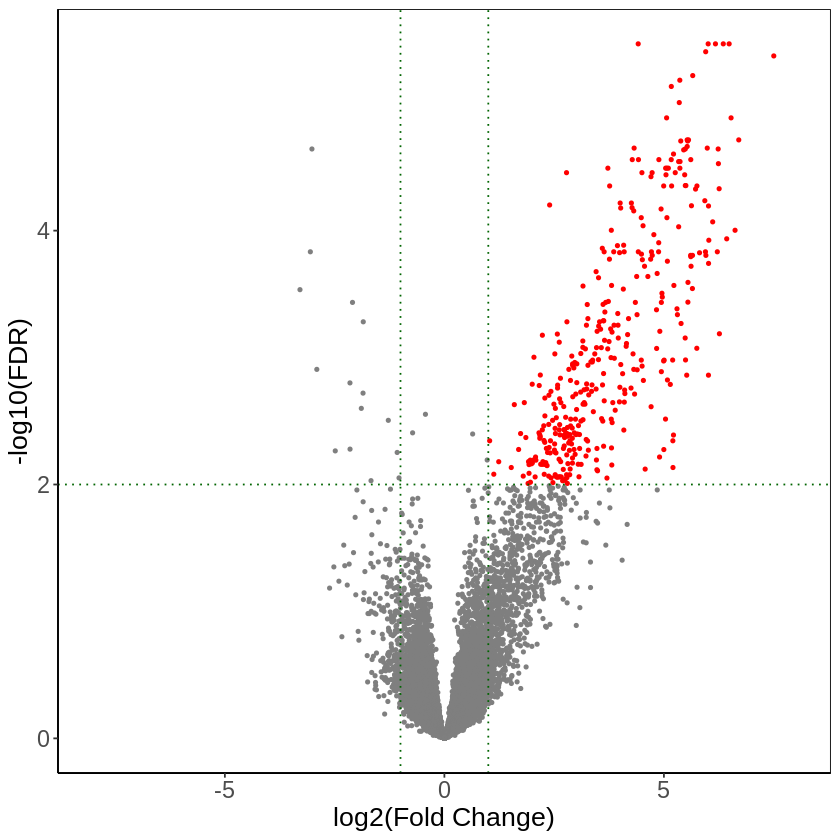

In [12]:
gdcVolcanoPlot(DEGAll_CHOL)

- The `Barplot` shows the composition of differntially expressed genes based on gene type.

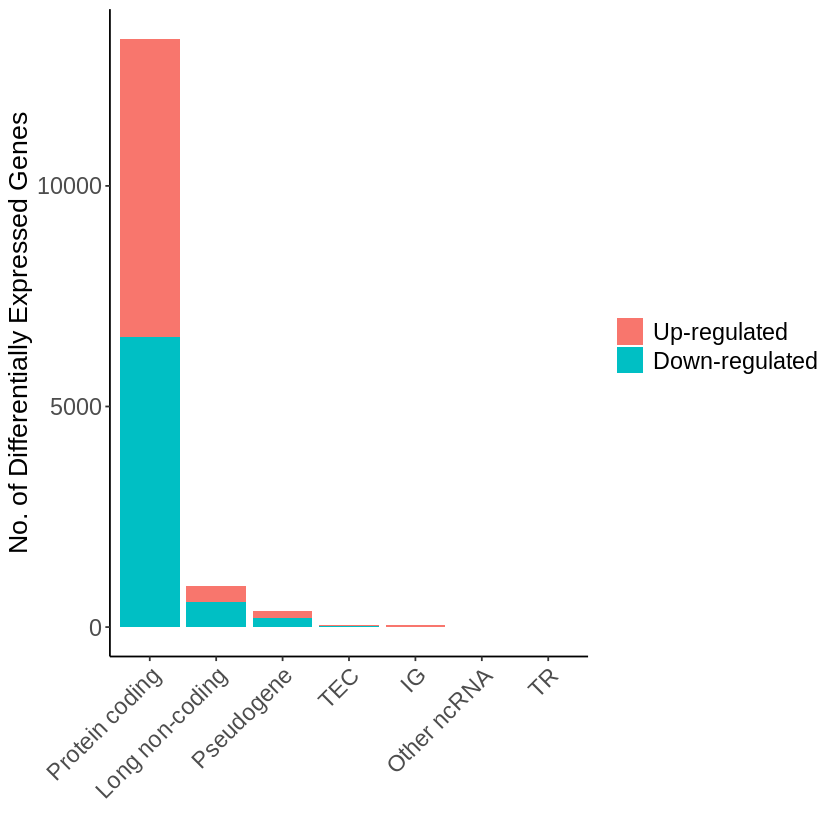

In [13]:
gdcBarPlot(deg = DEGAll_CHOL, angle = 45, data.type = 'RNAseq')

- Next step, we can filter out all the significant differentially expressed genes based on gene type.
- Filtering criteria used are `fc = 2, pval = 0.01`.

In [14]:
# all DE genes passed filtering
deALL_CHOL <- gdcDEReport(deg = DEGAll_CHOL, gene.type = 'all')

# DE long-noncoding
deLNC_CHOL <- gdcDEReport(deg = DEGAll_CHOL, gene.type = 'long_non_coding')

# DE protein coding genes
dePC_CHOL <- gdcDEReport(deg = DEGAll_CHOL, gene.type = 'protein_coding')

- A total of 361 protein coding genes were found differentially expressed between `PrimaryTumor` and `SolidTissueNormal` with statistical significance.

In [15]:
dim(dePC_CHOL)
dim(deLNC_CHOL)

[1] 361   8

[1] 7 8

- Visualize a correlation between two genes in the `dePC_CHOL dataset`. Both genes were identified as `up-regulated` in the tumor tissue.

`geom_smooth()` using formula 'y ~ x'



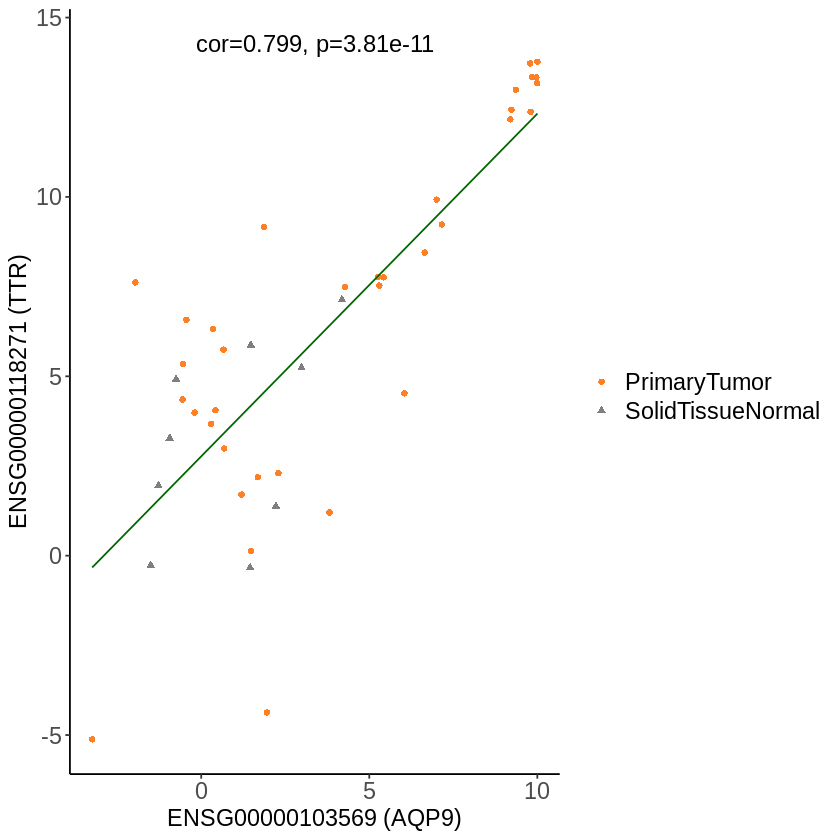

In [16]:
gdcCorPlot(gene1    = "ENSG00000103569", 
           gene2    = "ENSG00000118271", 
           rna.expr = rnaExpr, 
           metadata = metaMatrix.RNA)

## Functional enrichment analysis

The method of `gdcEnrichAnalysis` is able to take the output of `gdcDEReport` as input and perform gene enrichment analysis.

In [17]:
enrichOutput <- gdcEnrichAnalysis(gene = rownames(deALL_CHOL), simplify = TRUE)

### This step may take a few minutes ###


Step 1/5: BP analysis done!

Step 2/5: CC analysis done!

Step 3/5: MF analysis done!

Reading KEGG annotation online:


Reading KEGG annotation online:


Step 4/5: KEGG analysis done!

Step 5/5: DO analysis done!



In [18]:
enrichOutput[1:3,]

,Terms,Counts,GeneRatio,BgRatio,pValue,FDR,foldEnrichment,geneID,geneSymbol,Category
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,GO:0006631~fatty acid metabolic process,57,57/368,389/18285,1.122390e-32,2.118248e-29,7.280688,ENSG00000160868/ENSG00000138109/ENSG00000168306/ENSG00000183549/ENSG00000113790/ENSG00000186115/ENSG00000151726/ENSG00000187048/ENSG00000162365/ENSG00000198848/ENSG00000100197/ENSG00000119508/ENSG00000083807/ENSG00000100889/ENSG00000165841/ENSG00000183747/ENSG00000196177/ENSG00000167600/ENSG00000186480/ENSG00000166148/ENSG00000198610/ENSG00000138115/ENSG00000073734/ENSG00000130649/ENSG00000124253/ENSG00000135218/ENSG00000066813/ENSG00000165996/ENSG00000186204/ENSG00000166035/ENSG00000172831/ENSG00000163586/ENSG00000198099/ENSG00000243955/ENSG00000130208/ENSG00000130988/ENSG00000132855/ENSG00000184227/ENSG00000164120/ENSG00000197408/ENSG00000062282/ENSG00000079385/ENSG00000107537/ENSG00000119927/ENSG00000165475/ENSG00000110245/ENSG00000060971/ENSG00000009950/ENSG00000118137/ENSG00000106853/ENSG00000171503/ENSG00000116171/ENSG00000052802/ENSG00000110243/ENSG00000119673/ENSG00000163686/ENSG00000167315,CYP3A4/CYP2C9/ACOX2/ACSM5/EHHADH/CYP4F2/ACSL1/CYP4A11/CYP4A22/CES1/CYP2D6/NR4A3/SLC27A5/PCK2/CYP2C19/ACSM2A/ACADSB/CYP2S1/INSIG1/AVPR1A/AKR1C4/CYP2C8/ABCB11/CYP2E1/PCK1/CD36/ACSM2B/HACD1/CYP4F12/LIPC/CES2/FABP1/ADH4/GSTA1/APOC1/RGN/ANGPTL3/ACOT1/HPGD/CYP2B6/DGAT2/CEACAM1/PHYH/GPAM/CRYL1/APOC3/ACAA1/MLXIPL/APOA1/PTGR1/ETFDH/SCP2/MSMO1/APOA5/ACOT2/ABHD6/ACAA2,GO_BP
2,GO:0044282~small molecule catabolic process,56,56/368,374/18285,1.303537e-32,2.118248e-29,7.439840,ENSG00000160868/ENSG00000025423/ENSG00000168306/ENSG00000135094/ENSG00000100024/ENSG00000113790/ENSG00000186115/ENSG00000151790/ENSG00000187048/ENSG00000005421/ENSG00000119711/ENSG00000179761/ENSG00000146233/ENSG00000129596/ENSG00000100889/ENSG00000123453/ENSG00000183044/ENSG00000117009/ENSG00000110887/ENSG00000151224/ENSG00000196177/ENSG00000084110/ENSG00000198650/ENSG00000073734/ENSG00000144908/ENSG00000124253/ENSG00000118520/ENSG00000186204/ENSG00000036473/ENSG00000171759/ENSG00000163586/ENSG00000198099/ENSG00000130203/ENSG00000172482/ENSG00000113492/ENSG00000135929/ENSG00000132541/ENSG00000158104/ENSG00000176974/ENSG00000139344/ENSG00000111275/ENSG00000173597/ENSG00000166816/ENSG00000160282/ENSG00000107537/ENSG00000140263/ENSG00000109576/ENSG00000168237/ENSG00000113924/ENSG00000105852/ENSG00000060971/ENSG00000117305/ENSG00000171503/ENSG00000116171/ENSG00000008311/ENSG00000167315,CYP3A4/HSD17B6/ACOX2/SDS/UPB1/EHHADH/CYP4F2/TDO2/CYP4A11/PON1/ALDH6A1/PIPOX/CYP39A1/CDO1/PCK2/SARDH/ABAT/KMO/DAO/MAT1A/ACADSB/HAL/TAT/ABCB11/ALDH1L1/PCK1/ARG1/CYP4F12/OTC/PAH/FABP1/ADH4/APOE/AGXT/AGXT2/CYP27A1/RIDA/HPD/SHMT1/AMDHD1/ALDH2/SULT1B1/LDHD/FTCD/PHYH/SORD/AADAT/GLYCTK/HGD/PON3/ACAA1/HMGCL/ETFDH/SCP2/AASS/ACAA2,GO_BP
3,GO:0046395~carboxylic acid catabolic process,45,45/368,234/18285,4.016802e-31,4.351535e-28,9.555288,ENSG00000168306/ENSG00000135094/ENSG00000113790/ENSG00000186115/ENSG00000151790/ENSG00000187048/ENSG00000005421/ENSG00000119711/ENSG00000179761/ENSG00000129596/ENSG00000100889/ENSG00000123453/ENSG00000183044/ENSG00000117009/ENSG00000110887/ENSG00000151224/ENSG00000196177/ENSG00000084110/ENSG00000198650/ENSG00000073734/ENSG00000144908/ENSG00000124253/ENSG00000118520/ENSG00000186204/ENSG00000036473/ENSG00000171759/ENSG00000163586/ENSG00000172482/ENSG00000113492/ENSG00000132541/ENSG00000158104/ENSG00000176974/ENSG00000139344/ENSG00000166816/ENSG00000160282/ENSG00000107537/ENSG00000109576/ENSG00000113924/ENSG00000105852/ENSG00000060971/ENSG00000117305/ENSG00000171503/ENSG00000116171/ENSG00000008311/ENSG00000167315,ACOX2/SDS/EHHADH/CYP4F2/TDO2/CYP4A11/PON1/ALDH6A1/PIPOX/CDO1/PCK2/SARDH/ABAT/KMO/DAO/MAT1A/ACADSB/HAL/TAT/ABCB11/ALDH1L1/PCK1/ARG1/CYP4F12/OTC/PAH/FABP1/AGXT/AGXT2/RIDA/HPD/SHMT1/AMDHD1/LDHD/FTCD/PHYH/AADAT/HGD/PON3/ACAA1/HMGCL/ETFDH/SCP2/AASS/ACAA2,GO_BP


- Visualize the gene enrichment results as `barplot`

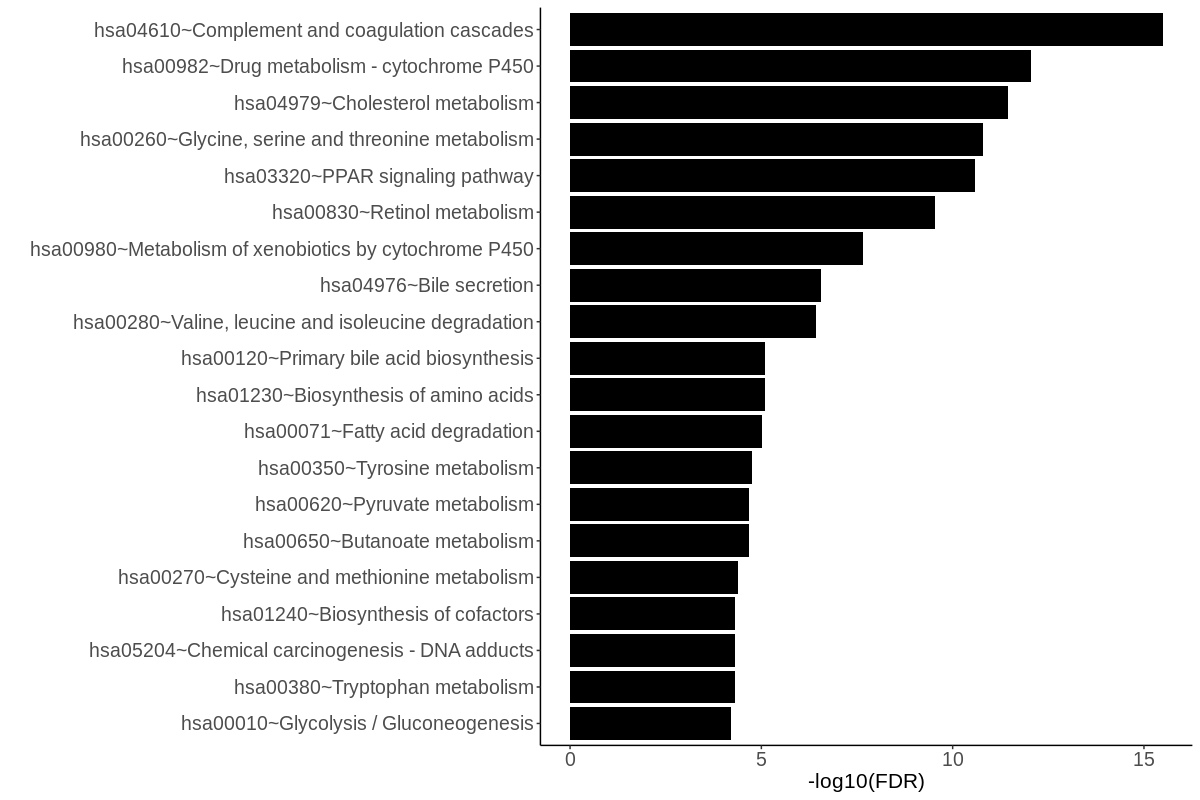

In [19]:
# adjust the plot size
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 100)
# plot result of gene enrichment analysis using KEGG category. 
gdcEnrichPlot(enrichOutput, type='bar', category='KEGG', num.terms = 20)

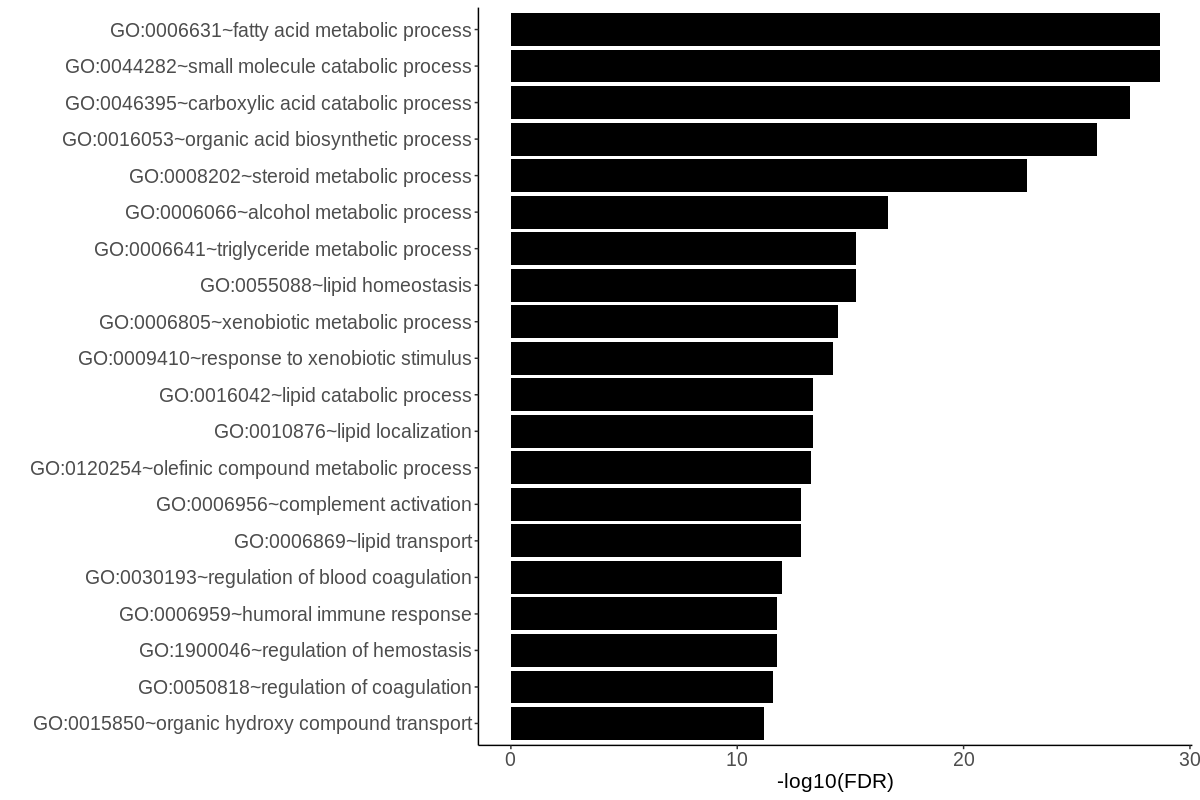

In [32]:
gdcEnrichPlot(enrichOutput, type='bar', category='GO_BP', num.terms = 20)

- Visualize the gene enrichment results as `bubble plot`

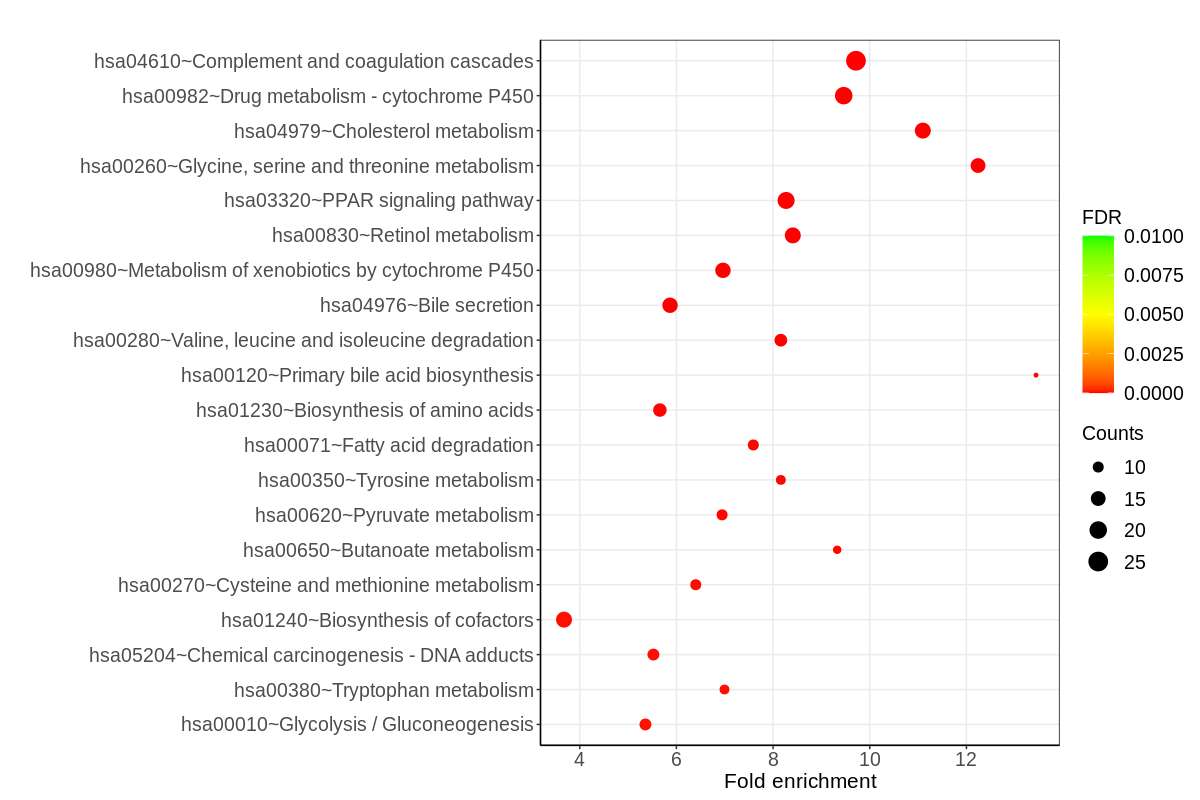

In [141]:
# alternatively, user can visualize the gene enrichment results in bubble plot
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 100)
gdcEnrichPlot(enrichOutput, type='bubble', category='KEGG', num.terms = 20)

- The next block shows the top 5 of gene enrichment analysis results based on `gene ontology biological process` (GO_BP) 
- We observed a lot of differentially expressed gene involved in `fatty acid metabolic process`, `small molecule catabolic process`, `organic acid biosynthetic process`. Liver is the central organ for fatty acid metabolism. 

In [68]:
enrichOutput[grep("GO_BP", enrichOutput$Category),] %>% arrange( desc(Counts)) %>% head(5)

,Terms,Counts,GeneRatio,BgRatio,pValue,FDR,foldEnrichment,geneID,geneSymbol,Category
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,GO:0006631~fatty acid metabolic process,57,57/368,389/18285,1.122390e-32,2.118248e-29,7.280688,ENSG00000160868/ENSG00000138109/ENSG00000168306/ENSG00000183549/ENSG00000113790/ENSG00000186115/ENSG00000151726/ENSG00000187048/ENSG00000162365/ENSG00000198848/ENSG00000100197/ENSG00000119508/ENSG00000083807/ENSG00000100889/ENSG00000165841/ENSG00000183747/ENSG00000196177/ENSG00000167600/ENSG00000186480/ENSG00000166148/ENSG00000198610/ENSG00000138115/ENSG00000073734/ENSG00000130649/ENSG00000124253/ENSG00000135218/ENSG00000066813/ENSG00000165996/ENSG00000186204/ENSG00000166035/ENSG00000172831/ENSG00000163586/ENSG00000198099/ENSG00000243955/ENSG00000130208/ENSG00000130988/ENSG00000132855/ENSG00000184227/ENSG00000164120/ENSG00000197408/ENSG00000062282/ENSG00000079385/ENSG00000107537/ENSG00000119927/ENSG00000165475/ENSG00000110245/ENSG00000060971/ENSG00000009950/ENSG00000118137/ENSG00000106853/ENSG00000171503/ENSG00000116171/ENSG00000052802/ENSG00000110243/ENSG00000119673/ENSG00000163686/ENSG00000167315,CYP3A4/CYP2C9/ACOX2/ACSM5/EHHADH/CYP4F2/ACSL1/CYP4A11/CYP4A22/CES1/CYP2D6/NR4A3/SLC27A5/PCK2/CYP2C19/ACSM2A/ACADSB/CYP2S1/INSIG1/AVPR1A/AKR1C4/CYP2C8/ABCB11/CYP2E1/PCK1/CD36/ACSM2B/HACD1/CYP4F12/LIPC/CES2/FABP1/ADH4/GSTA1/APOC1/RGN/ANGPTL3/ACOT1/HPGD/CYP2B6/DGAT2/CEACAM1/PHYH/GPAM/CRYL1/APOC3/ACAA1/MLXIPL/APOA1/PTGR1/ETFDH/SCP2/MSMO1/APOA5/ACOT2/ABHD6/ACAA2,GO_BP
2,GO:0044282~small molecule catabolic process,56,56/368,374/18285,1.303537e-32,2.118248e-29,7.439840,ENSG00000160868/ENSG00000025423/ENSG00000168306/ENSG00000135094/ENSG00000100024/ENSG00000113790/ENSG00000186115/ENSG00000151790/ENSG00000187048/ENSG00000005421/ENSG00000119711/ENSG00000179761/ENSG00000146233/ENSG00000129596/ENSG00000100889/ENSG00000123453/ENSG00000183044/ENSG00000117009/ENSG00000110887/ENSG00000151224/ENSG00000196177/ENSG00000084110/ENSG00000198650/ENSG00000073734/ENSG00000144908/ENSG00000124253/ENSG00000118520/ENSG00000186204/ENSG00000036473/ENSG00000171759/ENSG00000163586/ENSG00000198099/ENSG00000130203/ENSG00000172482/ENSG00000113492/ENSG00000135929/ENSG00000132541/ENSG00000158104/ENSG00000176974/ENSG00000139344/ENSG00000111275/ENSG00000173597/ENSG00000166816/ENSG00000160282/ENSG00000107537/ENSG00000140263/ENSG00000109576/ENSG00000168237/ENSG00000113924/ENSG00000105852/ENSG00000060971/ENSG00000117305/ENSG00000171503/ENSG00000116171/ENSG00000008311/ENSG00000167315,CYP3A4/HSD17B6/ACOX2/SDS/UPB1/EHHADH/CYP4F2/TDO2/CYP4A11/PON1/ALDH6A1/PIPOX/CYP39A1/CDO1/PCK2/SARDH/ABAT/KMO/DAO/MAT1A/ACADSB/HAL/TAT/ABCB11/ALDH1L1/PCK1/ARG1/CYP4F12/OTC/PAH/FABP1/ADH4/APOE/AGXT/AGXT2/CYP27A1/RIDA/HPD/SHMT1/AMDHD1/ALDH2/SULT1B1/LDHD/FTCD/PHYH/SORD/AADAT/GLYCTK/HGD/PON3/ACAA1/HMGCL/ETFDH/SCP2/AASS/ACAA2,GO_BP
3,GO:0016053~organic acid biosynthetic process,49,49/368,314/18285,2.015004e-29,1.309752e-26,7.753782,ENSG00000160868/ENSG00000132840/ENSG00000138109/ENSG00000183549/ENSG00000135094/ENSG00000100024/ENSG00000187048/ENSG00000162365/ENSG00000198848/ENSG00000100197/ENSG00000083807/ENSG00000146233/ENSG00000129596/ENSG00000183044/ENSG00000183747/ENSG00000117009/ENSG00000145692/ENSG00000021826/ENSG00000186480/ENSG00000166148/ENSG00000198610/ENSG00000138115/ENSG00000073734/ENSG00000130649/ENSG00000066813/ENSG00000165996/ENSG00000036473/ENSG00000166035/ENSG00000116761/ENSG00000171759/ENSG00000130208/ENSG00000172482/ENSG00000113492/ENSG00000135929/ENSG00000180432/ENSG00000176974/ENSG00000130988/ENSG00000060982/ENSG00000079385/ENSG00000182551/ENSG00000110245/ENSG00000009950/ENSG00000118137/ENSG00000116171/ENSG00000143627/ENSG00000110243/ENSG00000008311/ENSG00000171766/ENSG00000161653,CYP3A4/BHMT2/CYP2C9/ACSM5/SDS/UPB1/CYP4A11/CYP4A22/CES1/CYP2D6/SLC27A5/CYP39A1/CDO1/ABAT/ACSM2A/KMO/BHMT/CPS1/INSIG1/AVPR1A/AKR1C4/CYP2C8/ABCB11/CYP2E1/ACSM2B/HACD1/OTC/LIPC/CTH/PAH/APOC1/AGXT/AGXT2/CYP27A1/CYP8B1/SHMT1/RGN/BCAT1/CEACAM1/ADI1/APOC3/MLXIPL/APOA1/SCP2/P

- The next block shows the top 5 of gene enrichment analysis results based on `Kyoto Encyclopedia of Genes and Genomes` (KEGG)
- We observed the a lot of differentially expressed genes were enriched in `Complement and coagulation cascades`, `Drug metabolism`, `PPAR signaling pathway`, and `Cholesterol metabolism`.

In [130]:
enrichOutput[grep("KEGG", enrichOutput$Category),] %>% arrange(desc(Counts)) %>% head(5)

,Terms,Counts,GeneRatio,BgRatio,pValue,FDR,foldEnrichment,geneID,geneSymbol,Category
,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,hsa04610~Complement and coagulation cascades,25,25/243,84/7932,1.301771e-18,3.228391e-16,9.714874,,,KEGG
2,hsa00982~Drug metabolism - cytochrome P450,20,20/243,69/7932,7.397923e-15,9.173424e-13,9.461442,,,KEGG
3,hsa03320~PPAR signaling pathway,19,19/243,75/7932,5.342162e-13,2.649712e-11,8.269300,,,KEGG
4,hsa04979~Cholesterol metabolism,17,17/243,50/7932,4.224998e-14,3.492665e-12,11.098272,,,KEGG
5,hsa00830~Retinol metabolism,17,17/243,66/7932,6.966688e-12,2.879564e-10,8.407782,,,KEGG


- In this gene enrichment output, few differentially expressed genes, such as apolipoprotein A2 (APOA2), apolipoprotein B (APOB), fibrinogen alpha chain (FGA), fibrinogen gamma chain (FGG), were previsouly reported to be nefatively correlated with the tumor stage of CCA patients. ([Li et al. 2019](https://pubmed.ncbi.nlm.nih.gov/31545466/))

## Univariate survival analysis

- In this analysis, we uses Kaplan Meier(KM) method based on the `survival` R package. KM analysis divides patients into high-expression and low-expression groups by a user-defined threshold. We used `median` as the threshold in this analysis.
- The next block shows how to conduct KM survival analysis using differentially expressed gene list, metadata, and normalized expression quantification dataframe.

In [20]:
survOutput <- gdcSurvivalAnalysis(gene     = rownames(deALL_CHOL), 
                                  method   = 'KM', 
                                  rna.expr = rnaExpr, 
                                  metadata = metaMatrix.RNA, 
                                  sep      = 'median')

- Inspect the first five lines of survival analysis

In [45]:
# Sort the output of univariate survival analysis based on pvalue
survOutput$pValue <- as.numeric(survOutput$pValue)
sorted_survOutput<- survOutput[order(survOutput$pValue),]
sorted_survOutput[1:5,]

,symbol,HR,lower95,upper95,pValue
,<chr>,<chr>,<chr>,<chr>,<dbl>
ENSG00000123358,NR4A1,0.265008942850108,0.105127510696949,0.668043401055915,0.0116
ENSG00000116785,CFHR3,3.12054093878408,1.2339512529299,7.89154006489807,0.0167
ENSG00000135929,CYP27A1,2.866063444389,1.1207663875984,7.32919880374424,0.0269
ENSG00000130222,GADD45G,2.55988000772578,0.956995777323486,6.84745513954245,0.0305
ENSG00000119508,NR4A3,0.344812485123398,0.136685987765886,0.86984519657287,0.0331


- The next block shows the KM survival plot using the top gene (ENSG00000123358) from survival analysis output.

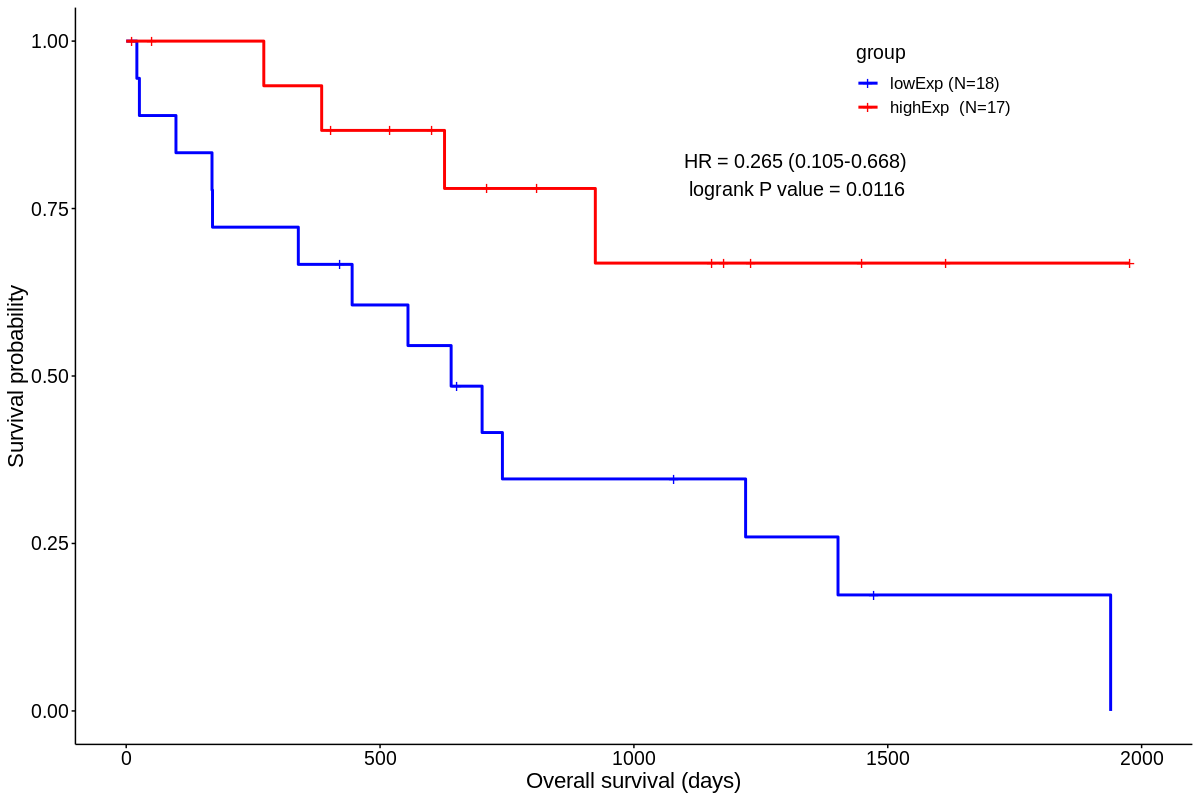

In [44]:
# pick the most significant gene ENSG00000123358 for KM visualization
gdcKMPlot(gene     = 'ENSG00000123358',
          rna.expr = rnaExpr,
          metadata = metaMatrix.RNA,
          sep      = 'median')